# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>

In [1]:
import pandas as pd
from collections import Counter
from openpyxl import Workbook
df = pd.read_excel("marketing_case_v.0.7.xlsx", sheet_name="C2", engine = 'openpyxl')
df.tail(10)


Дата просмотра рекламы  Кол-во пользователей, просмотревших рекламу  \
499990             2020-02-24                                           20   
499991             2020-08-05                                            5   
499992             2020-08-31                                           24   
499993             2020-08-05                                            4   
499994             2020-08-03                                           11   
499995             2020-12-04                                           27   
499996             2020-03-23                                           26   
499997             2020-10-22                                            5   
499998             2020-04-20                                           25   
499999             2020-12-06                                           26   

        Количество просмотров рекламы Локальное время покупки  Код региона   \
499990                             21  2020-02-15T23:46+00:03            38   
499991                             29  2020-02-19T09:27+00:03            38   
499992                              5  2020-02-06T20:03+00:03            38   
499993                              9  2020-02-13T20:54+00:03            38   
499994                             29  2020-03-04T22:14+00:03            38   
499995                              1  2020-02-01T01:50+00:03            38   
499996                              3  2020-01-11T06:01+00:03            38   
499997                             12  2020-01-16T04:13+00:03            38   
499998                             19  2020-02-09T06:17+00:03            38   
499999                             10  2020-01-11T05:16+00:03            38   

       Часовой пояс  Кол-во покупок  Кол-во товаров в покупке     Бренд  \
499990        UTC+5               1                         1   NETGEAR   
499991        UTC+5               1                         1  Kingston   
499992        UTC+5               1                         1        HP   
499993        UTC+5               3                         3        LG   
499994        UTC+5               3                         3    Lenovo   
499995        UTC+5               4                         4        LG   
499996        UTC+5               2                         2      Acer   
499997        UTC+5               4                         4        HP   
499998        UTC+5               5                         5    Bradex   
499999        UTC+5               4                         4      BenQ   

                     Категории   
499990   Антенны для Wi-Fi и 3G  
499991       Оперативная память  
499992                 Ноутбуки  
499993                  Монитор  
499994                 Ноутбуки  
499995                  Монитор  
499996                 Ноутбуки  
499997                  Монитор  
499998  Подставки для ноутбуков  
499999                  Монитор

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   Дата просмотра рекламы                       500000 non-null  object
 1   Кол-во пользователей, просмотревших рекламу  500000 non-null  int64 
 2   Количество просмотров рекламы                500000 non-null  int64 
 3   Локальное время покупки                      500000 non-null  object
 4   Код региона                                  500000 non-null  int64 
 5   Часовой пояс                                 500000 non-null  object
 6   Кол-во покупок                               500000 non-null  int64 
 7   Кол-во товаров в покупке                     500000 non-null  int64 
 8   Бренд                                        499751 non-null  object
 9   Категории                                    500000 non-null  object
d

Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 0'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>

In [4]:
QI = ['Дата просмотра рекламы',
      'Количество просмотров рекламы',
      'Кол-во покупок',
      'Бренд',
      'Категории ']
SI = ['Кол-во пользователей, просмотревших реклам']

In [5]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  return min(aggregrate)
print('k-anonymity = ' + str(k_anonymous(df, QI)))

k-anonymity = 1


#### Количество уникальных строк

In [ ]:
unique_rows = df[QI].drop_duplicates()
unique_rows.to_excel("uniques_row.xlsx")
print(f"Количество уникальных строк = {len(unique_rows)}")

In [ ]:
print(unique_rows)

#### Графики подсчета этих типов данных показаны ниже.

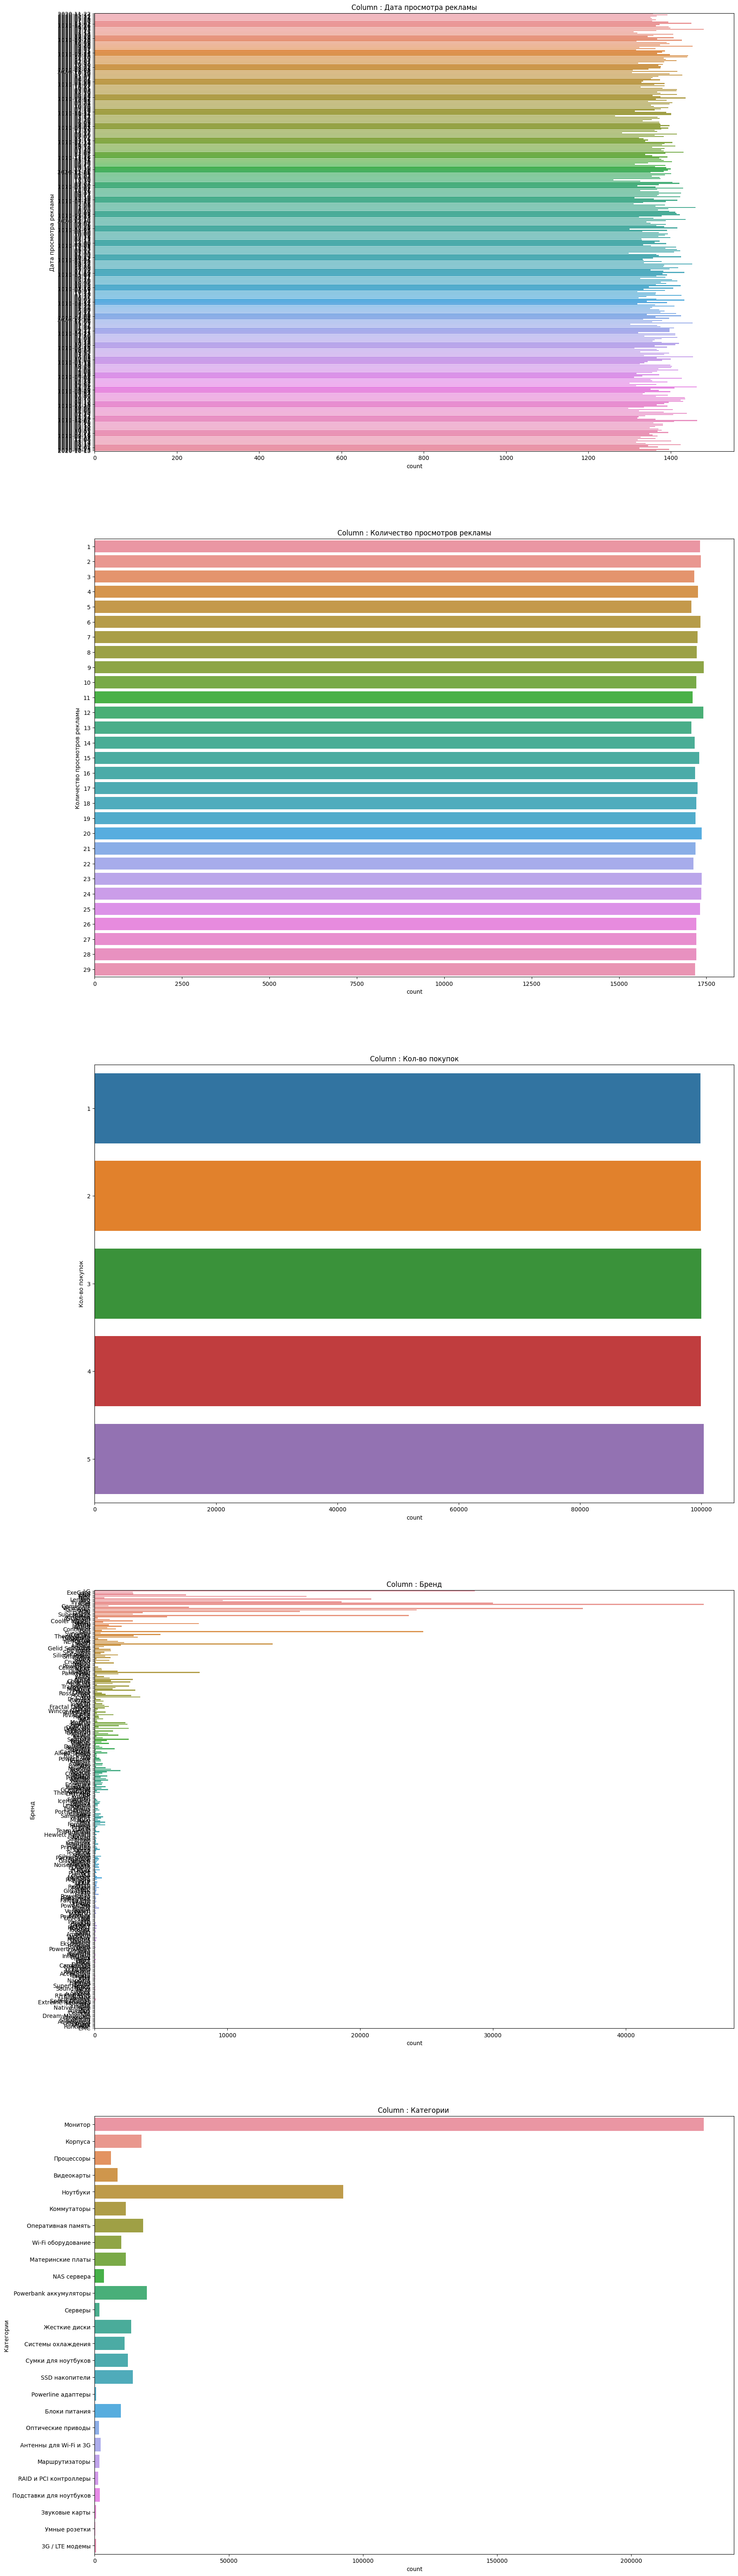

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

columns =  QI

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])

#### Количество повторных значений

In [7]:
def quantity_qi(arg):         
    quantity = Counter(df[arg])
    dic_quan = dict(quantity)
    for idx, item in enumerate(dic_quan.items(),1):
        if(arg == 'Дата просмотра рекламы'):
            ws['A' + str(idx + 1)] = f"{item[0]}:{item[1]}"
            ws['A1'] = f"{arg}"
        elif(arg == 'Количество просмотров рекламы'):
            ws['B' + str(idx + 1)] = f"{item[0]}:{item[1]}"
            ws['B1'] = f"{arg}"
        elif(arg == 'Кол-во покупок'):
            ws['C' + str(idx + 1)] = f"{item[0]}:{item[1]}"
            ws['C1'] = f"{arg}"
        elif(arg == 'Бренд'):
            ws['D' + str(idx +1)] = f"{item[0]}:{item[1]}"
            ws['D1'] = f"{arg}"
        elif(arg == 'Категории '):
            ws['E' + str(idx +1)] = f"{item[0]}:{item[1]}"
            ws['E1'] = f"{arg}"

 #### Создается Excel файл, где в каждой ячейке после стрелочки выводиться количество повторов “имени” ячейки в исходном датасете.

In [8]:
wb = Workbook()
ws = wb.create_sheet("C2")
for arg in QI:
    quantity_qi(arg)
wb.save('quantity.xlsx')
df2 = pd.read_excel('quantity.xlsx', sheet_name="C2", engine = 'openpyxl')
df2.head(10)

Дата просмотра рекламы Количество просмотров рекламы Кол-во покупок  \
0        2020-11-22:1357                      25:17323        1:99838   
1        2020-05-14:1392                      17:17253        3:99964   
2        2020-02-27:1366                      22:17133        4:99908   
3        2020-05-27:1351                      11:17101       5:100366   
4        2020-03-29:1354                      16:17181        2:99924   
5        2020-07-20:1364                      10:17210            NaN   
6        2020-01-24:1355                      29:17182            NaN   
7        2020-11-23:1394                      14:17163            NaN   
8        2020-03-01:1450                      27:17208            NaN   
9        2020-12-27:1373                      15:17296            NaN   

          Бренд                Категории   
0      LG:28638            Монитор:226964  
1  ExeGate:2866             Корпуса:17497  
2     Eizo:2908           Процессоры:6094  
3    Intel:6876           Видеокарты:8602  
4     NEC:15952            Ноутбуки:92650  
5     Palit:742         Коммутаторы:11670  
6  Lenovo:20848  Оперативная память:18058  
7      MSI:9657   Wi-Fi оборудование:9989  
8  Iiyama:18606   Материнские платы:11588  
9    Acer:30012          NAS сервера:3425